
# Часть 3. Классификация текстов
**Задача** классификации формулируется так: 
данный фрагмент фанфика описывает какую-то ситуацию, которая предшествует произнесению заклинания. Требуется по тексту предсказать, какое именно заклинание будет произнесено. Таким образом, заклинание - это фактически метка класса. Основная мера качества – macro  𝐹1 . Обучите несколько классификаторов и сравните их между собой. Оцените качество классификаторов на частых и редких классах. Какие классы чаще всего оказываются перепутаны? Связаны ли ошибки со смыслом заклинаний?

**Данные**

train - данные для обучения

dev - валидационная выборка для отладки

test – тестовая выборка

[1 балл] Используйте fastText в качестве baseline-классификатора.

[2 балла] Используйте сверточные сети в качестве более продвинутого классификатора. Поэкспериментируйте с количеством и размерностью фильтров, используйте разные размеры окон, попробуйте использовать  𝑘 -max pooling.

[2 балла] Попробуйте расширить обучающее множество за счет аугментации данных. Если вам понадобится словарь синонимов, можно использовать WordNet (ниже вы найдете примеры).

[бонус] Используйте результат max pooling'а как эмбеддинг входного текста. Визуализируйте эмбеддинги 500-1000 предложений из обучающего множества и изучите свойства получившегося пространства.

[бонус] Используйте ваш любимый классификатор и любые (честные) способы повышения качества классификации и получите macro  𝐹1  больше 0.5.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/My Drive/Colab Notebooks/nlp/hw1-harry-potter'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим данные и установим нужные библиотеки для работы с нейронными сетями:

In [ ]:
import re
import gensim
import logging
import nltk.data 
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer

In [ ]:
# тренировочные данные для классификаторов
import pandas as pd

train_data = pd.read_csv(path + '/hpac_splits/hpac_corpus/hpac_training_128.tsv', sep = '\t', header = None)
test_data = pd.read_csv(path + '/hpac_splits/hpac_corpus/hpac_test_128.tsv', sep = '\t', header = None)
dev_data = pd.read_csv(path + '/hpac_splits/hpac_corpus/hpac_dev_128.tsv', sep = '\t', header = None)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from string import punctuation
punctuation

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#!pip3 install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip3 install torch torchvision torchaudio
!pip3 install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0

     |████████████████████████████████| 735.5 MB 14 kB/s 
     |████████████████████████████████| 17.3 MB 40 kB/s 
     |████████████████████████████████| 1.9 MB 40.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.8.0 which is incompatible.


In [ ]:
#!pip install torchvision

In [ ]:
!pip install torchtext==0.9.0

     |████████████████████████████████| 7.1 MB 9.9 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.10.0
    Uninstalling torchtext-0.10.0:
      Successfully uninstalled torchtext-0.10.0


In [ ]:
!pip install spacy

In [ ]:
#!python3.6 -m spacy download en
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 8.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
import spacy
#import en
en_nlp = spacy.load('en_core_web_sm')

Подготовим тексты:

In [ ]:
train_clean = train_data.copy()
dev_clean = dev_data.copy()
test_clean = test_data.copy()

In [ ]:
# заклинания из обучающей выборки
print(train_clean[1].unique())
print('\n Всего различных классов получается: ', len(train_clean[1].unique()))

['RIDDIKULUS' 'STUPEFY' 'ACCIO' 'EXPELLIARMUS' 'PROTEGO' 'LUMOS' 'CRUCIO'
 'REDUCTO' 'AVADA_KEDAVRA' 'WINGARDIUM_LEVIOSA' 'SCOURGIFY'
 'PETRIFICUS_TOTALUS' 'INCENDIO' 'DEPRIMO' 'IMPERIO' 'EVANESCO'
 'ALOHOMORA' 'EXPECTO_PATRONUM' 'REDUCIO' 'OBLIVIATE' 'SONORUS'
 'SECTUMSEMPRA' 'CONFRINGO' 'LEGILIMENS' 'DIFFINDO' 'TARANTALLEGRA'
 'OPPUGNO' 'COLLOPORTUS' 'APARECIUM' 'IMPEDIMENTA' 'TERGEO' 'MUFFLIATO'
 'INCARCEROUS' 'RELASHIO' 'SILENCIO' 'LEVICORPUS' 'LOCOMOTOR' 'AVIS'
 'MORSMORDRE' 'PROTEGO_TOTALUM' 'REPARO' 'AGUAMENTI' 'EPISKEY' 'NOX'
 'MOBILICORPUS' 'PORTUS' 'FINITE_INCANTATEM' 'LANGLOCK' 'IMPERVIUS'
 'ENGORGIO' 'CAVE_INIMICUM' 'SALVIO_HEXIA' 'RENNERVATE' 'POINT_ME'
 'DENSAUGEO' 'QUIETUS' 'GEMINIO' 'FERULA' 'HOMENUM_REVELIO' 'ORCHIDEOUS'
 'LOCOMOTOR_MORTIS' 'CONFUNDO' 'DELETRIUS' 'EXPULSO' 'OBSCURO'
 'PRIOR_INCANTATO' 'RICTUSEMPRA' 'SPECIALIS_REVELIO' 'FLAGRATE'
 'PIERTOTUM_LOCOMOTOR' 'DEFODIO' 'FURNUNCULUS' 'WADDIWASI'
 'METEOLOJINX_RECANTO' 'PROTEGO_HORRIBILIS' 'LIBERACORPUS' 'SERPEN

In [ ]:
# очистим тексты от стоп-слов, пунктуации, приведем к нижнему регистру

from string import punctuation
punctuation

import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer

porter=PorterStemmer()
tok = WordPunctTokenizer()
pat = r'@[A-Za-z0-9]+'
stops = set(stopwords.words('english') + list(punctuation))
def text_cleaner(text):
    clean = re.sub(pat, '', text)
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()

    words = tok.tokenize(lower_case)
    
    stem_sentence=[]
    for word in words:
        if word not in stops:
          stem_sentence.append(porter.stem(word))
          stem_sentence.append(" ")
    words="".join(stem_sentence).strip()
    return words

In [ ]:
for i in range(len(train_clean)):
  train_clean.iloc[i][2] = text_cleaner(train_clean.iloc[i][2])

for i in range(len(test_clean)):
  test_clean.iloc[i][2] = text_cleaner(test_clean.iloc[i][2])

for i in range(len(dev_clean)):
  dev_clean.iloc[i][2] = text_cleaner(dev_clean.iloc[i][2])

train_clean.set_axis([0, 'label', 'text'], axis=1, inplace=True)
test_clean.set_axis([0, 'label', 'text'], axis=1, inplace=True)
dev_clean.set_axis([0, 'label', 'text'], axis=1, inplace=True)

In [ ]:
train_clean.head()

,0,label,text
0,7642954.0.676,RIDDIKULUS,stare next face boggart defens dark art class ...
1,10443333.0.5753,RIDDIKULUS,whole time first reaction felt quit proud sinc...
2,4703706.0.8690,STUPEFY,watch inglori withdraw togeth accompani philli...
3,4593427.0.1815,ACCIO,wand incendio wretch chilli weather get nerv f...
4,4278446.0.2692,EXPELLIARMUS,alreadi compar everyday al give let see dada c...


## fastText классификатор

In [ ]:
! git clone https://github.com/facebookresearch/fastText.git
! pip3 install fastText/.

Cloning into 'fastText'...
remote: Enumerating objects: 3854, done.
remote: Total 3854 (delta 0), reused 0 (delta 0), pack-reused 3854
Receiving objects: 100% (3854/3854), 8.22 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (2417/2417), done.
Processing ./fastText
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Using cached pybind11-2.7.1-py2.py3-none-any.whl (200 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3086003 sha256=533a8a88833e45afbe36cca20651a70b9f2b15a6ecc6de99887a0e2facf2181a
  Stored in directory: /tmp/pip-ephem-wheel-cache-h8gtxeq6/wheels/22/04/6e/b3aba25c1a5845898b5871a0df37c2126cb0

In [ ]:
# сохраним предобработанные тексты в файлы для fastText классификатора

with open(path + '/data.train.txt', 'w+') as outfile:
    for i in range(len(train_clean)):
        text = train_clean.iloc[i]["text"]
        label = train_clean.iloc[i]["label"]
        outfile.write('__label__' + label + ' '+ text + '\n')

with open(path + '/data.dev.txt', 'w+') as outfile:
    for i in range(len(dev_clean)):
        text = dev_clean.iloc[i]["text"]
        label = dev_clean.iloc[i]["label"]
        outfile.write('__label__' + label + ' '+ text + '\n')

with open(path + '/data.test.txt', 'w+') as outfile:
    for i in range(len(test_clean)):
        text = test_clean.iloc[i]["text"]
        label = test_clean.iloc[i]["label"]
        outfile.write('__label__' + label + ' '+ text + '\n')

Обучим fasttext классификатор на тренировочной выборке, тьюнинг парметров будет производиться по валидационным данным.

In [ ]:
import fasttext

#classifier = fasttext.train_supervised(path + '/data.train.txt')
classifier = fasttext.train_supervised(input=path + '/data.train.txt', autotuneValidationFile=path + '/data.dev.txt', loss='ova')

In [ ]:
classifier_1 = fasttext.train_supervised(input=path + '/data.train.txt', autotuneValidationFile=path + '/data.dev.txt', loss='ova', autotuneMetric="f1")

In [ ]:
for i in range(1, 6):
  print_results(classifier_1, path + '/data.test.txt', i)

Number of examples:	7679
Precision@1	0.311
Recall@1	0.311
F1@1	0.311

Number of examples:	7679
Precision@2	0.215
Recall@2	0.429
F1@2	0.286

Number of examples:	7679
Precision@3	0.168
Recall@3	0.503
F1@3	0.251

Number of examples:	7679
Precision@4	0.140
Recall@4	0.561
F1@4	0.224

Number of examples:	7679
Precision@5	0.121
Recall@5	0.607
F1@5	0.202



In [ ]:
def print_results(model, input_path, k):
    num_examples, precision_at_k, recall_at_k = model.test(input_path, k)
    f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)

    print("Number of examples:\t{}".format(num_examples))
    print("Precision@{}\t{:.3f}".format(k, precision_at_k))
    print("Recall@{}\t{:.3f}".format(k, recall_at_k))
    print("F1@{}\t{:.3f}".format(k, f1_at_k))
    print()

In [ ]:
for i in range(1, 6):
  print_results(classifier, path + '/data.test.txt', i)

Number of examples:	7679
Precision@1	0.312
Recall@1	0.312
F1@1	0.312

Number of examples:	7679
Precision@2	0.214
Recall@2	0.429
F1@2	0.286

Number of examples:	7679
Precision@3	0.167
Recall@3	0.501
F1@3	0.251

Number of examples:	7679
Precision@4	0.140
Recall@4	0.560
F1@4	0.224

Number of examples:	7679
Precision@5	0.121
Recall@5	0.605
F1@5	0.202



In [ ]:
preds = []
probs = []
y_true = []
for i in range(len(test_clean)):
      y_true.append('__label__' +test_clean.iloc[i]["label"])
      prediction = classifier_1.predict(test_clean.iloc[i]["text"])
      preds.append(prediction[0][0])
      probs.append(prediction[1][0])

In [ ]:
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score
print('f1-macro по всем классам у fastText классификатора: ', f1_score(y_true, preds, average='macro'))

f1-macro по всем классам у fastText классификатора:  0.09051639264257937


In [ ]:
from sklearn.metrics import classification_report
print('Результат работы классификатора на тестовых данных: ')
#print(classification_report(y_true_le, preds_le, target_names=target_names))
print(classification_report(y_true, preds))

Результат работы классификатора на тестовых данных: 
                              precision    recall  f1-score   support

              __label__ACCIO       0.31      0.38      0.34       516
          __label__AGUAMENTI       0.18      0.11      0.14        79
          __label__ALOHOMORA       0.37      0.46      0.41       164
            __label__ANAPNEO       0.00      0.00      0.00         4
          __label__APARECIUM       0.00      0.00      0.00         9
      __label__AVADA_KEDAVRA       0.41      0.55      0.47       915
               __label__AVIS       0.00      0.00      0.00        27
      __label__CAVE_INIMICUM       0.00      0.00      0.00         2
        __label__COLLOPORTUS       0.20      0.03      0.05        39
          __label__CONFRINGO       0.00      0.00      0.00        43
           __label__CONFUNDO       0.00      0.00      0.00        17
             __label__CRUCIO       0.41      0.56      0.47       909
            __label__DEFODIO       0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Выводы:**

Получаем, что лучше всего определяются на тестовой выборке заклинания:

**REDDIKULUS** (f1-score = **74%**)

**EXPECTO_PATRONUM** (f1-score = **56%**)

**LUMUS** (f1-score = **48%**)

**AVADA_KEDAVRA** (f1-score = **47%**)

**CRUCIO** (f1-score = **47%**)

**LEGILIMENS** (f1-score = **44%**)


Больше всего текстов протестированно с классами  AVADA_KEDAVRA (убийство) и CRUCIO, а именно 915 и 909 раз, соответственно. Текстов для LUMUS (зажечь свечу) в выборке чуть меньше - 501, однако, классификатор тоже выдал неплохой результат. C заклинанием REDDIKULUS (применяли для превращения боггарта из страха во что-то смешное) протестировано значительно меньше текстов - 83, но точность и полнота имеют большие показатели. 

Для большинства заклинаний f1-score принимает вообще нулевые значения, особенно, если их меньше 100 в выборке. Как видно из результатов, он путается в отрывках предшествующихб например, заклинаниям STUPEFY (на 423 тестах метрика получилась только 23%), IMPERIO (из 138 примеров, практически все неправильно классифицированны), для EXPELLIARMUS тоже качество оставляет желать лучшего (f1-score = 18% на 335 примерах).

Поэтому,  f1-macro получается маленький - **9%**, если усреднять по всем классам, однако, некоторые заклинания классификатор fastText распознает достаточно хорошо.


## CNN

In [ ]:
train_df = train_clean.copy()
dev_df = dev_clean.copy()
test_df = test_clean.copy()

In [ ]:
# используем, чтобы сделать из датафрейма с текстами torchtext-датасет
# функция взята с https://coderoad.ru/52602071/Dataframe-%D0%BA%D0%B0%D0%BA-%D0%B8%D1%81%D1%82%D0%BE%D1%87%D0%BD%D0%B8%D0%BA-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B2-torchtext

import torch
from torchtext import data
from torchtext.legacy import data
from torchtext.legacy.data import Field, Dataset, Example
import pandas as pd


class DataFrameDataset(Dataset):
    """Class for using pandas DataFrames as a datasource"""

    def __init__(self, examples, fields, filter_pred=None):
        """
        Create a dataset from a pandas dataframe of examples and Fields
        Arguments:
            examples pd.DataFrame: DataFrame of examples
            fields {str: Field}: The Fields to use in this tuple. The
                string is a field name, and the Field is the associated field.
            filter_pred (callable or None): use only exanples for which
                filter_pred(example) is true, or use all examples if None.
                Default is None
        """
        self.examples = examples.apply(
            SeriesExample.fromSeries, args=(fields,), axis=1).tolist()
        if filter_pred is not None:
            self.examples = filter(filter_pred, self.examples)
        self.fields = dict(fields)
        # Unpack field tuples
        for n, f in list(self.fields.items()):
            if isinstance(n, tuple):
                self.fields.update(zip(n, f))
                del self.fields[n]

class SeriesExample(Example):
    """Class to convert a pandas Series to an Example"""

    def __str__(self):
        # todo: implement something more usefull :)
        return str(self)

    @classmethod
    def fromSeries(cls, data, fields):
        return cls.fromdict(data.to_dict(), fields)

    @classmethod
    def fromdict(cls, data, fields):
        ex = cls()

        for key, field in fields.items():
            if key not in data:
                raise ValueError("Specified key {} was not found in "
                                 "the input data".format(key))
            if field is not None:
                setattr(ex, key, field.preprocess(data[key]))
            else:
                setattr(ex, key, data[key])
        return ex

In [ ]:
import torch
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data
from torchtext.vocab import build_vocab_from_iterator

print(torch.__version__)

SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField()

1.8.0


In [ ]:
# создаем тренировочный, валидационный и тестовый torchtext датасеты с полями 'label' и 'text'

fields = { 'label' : LABEL, 'text' : TEXT }
train_ds = DataFrameDataset(train_df, fields)
dev_ds = DataFrameDataset(dev_df, fields)
test_ds = DataFrameDataset(test_df, fields)

In [ ]:
len(train_ds),len(dev_ds), len(test_ds)

(60980, 7605, 7679)

In [ ]:
TEXT.build_vocab(train_ds, max_size=25000)
LABEL.build_vocab(train_ds)

In [ ]:
print(len(LABEL.vocab))

85


In [ ]:
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, dev_ds, test_ds), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

In [ ]:
# import torch.nn.functional as F

# def calc_metric(preds, y):
#     rounded_preds = torch.round(F.sigmoid(preds))
#     correct = (rounded_preds == y).float()
#     acc = correct.sum() / len(correct)
#     return acc

In [ ]:
def train_func(model, iterator, optimizer, criterion):
    epoch_loss = 0
    res_preds = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        
        predictions = model(batch.text.cuda()).squeeze(1)
        loss = criterion(predictions, batch.label.cuda())        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        #res_preds += predictions
    # f1_score = calc_metric(res_preds, iterator.label.cuda())   
    return epoch_loss / len(iterator) #, f1_score

In [ ]:
def evaluate_func(model, iterator, criterion):
    epoch_loss = 0
    res_preds = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text.cuda()).squeeze(1)

            loss = criterion(predictions, batch.label.cuda())
            epoch_loss += loss
            
            #res_preds += predictions
    # f1_score = calc_metric(res_preds, iterator.label.cuda()) 
    return epoch_loss / len(iterator) #, f1_score

In [ ]:
TEXT.build_vocab(train_ds, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train_ds)


BATCH_SIZEBATCH_S  = 16

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, dev_ds, test_ds), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

По честному нужно тьюнить гиперпараметры с помощью какого-нибудь фреймворка, как в керасе keras-tuner, но пока только руками позапускала с разными batch_size, learning rate, dropout, размерами фильтров и количеством слоев в сверточной нейронной сети, остановимся на таком классификаторе:

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_0 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[1], embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_sizes[2], embedding_dim))
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        # self.fc = nn.Linear(, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [sent len, batch size]
        x = x.permute(1, 0)
                
        #x = [batch size, sent len]
        embedded = self.embedding(x)
                
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
            
        # эксперементируем с k-max пулингом 
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

In [ ]:
print('Размер словаря: ', len(TEXT.vocab))

Размер словаря:  25002


Так как здесь стоит задача multilable classification, то резонно выбрать nn.CrossEntropyLoss() в качестве лосс функции, а OUTPUT_DIM должна равняться их количеству и будет содержать вероятности попадания в каждый клаас, из которого выбирается наиболее вероятный. Вдохновившись статьей, в качестве оптимизатора выбирали Adam с lr=0.001

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 250
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.5

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

Векторизуем слова из текстов датасета:


In [ ]:
TEXT.build_vocab(train_ds, max_size=25000, vectors="glove.6B.100d")
LABEL.build_vocab(train_ds)

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-1.0889,  0.1550,  0.3195,  ..., -0.5389, -0.0420, -0.2176],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.6714, -0.0377, -0.5189,  ..., -0.3430,  0.1925,  0.3466]])

In [ ]:
BATCH_SIZE  = 128

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_ds, dev_ds, test_ds), 
    batch_size=BATCH_SIZE, 
    sort_key=lambda x: len(x.text), 
    repeat=False)

In [ ]:
!nvidia-smi

Mon Oct  4 11:18:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

model = model.cuda()


Классификатор тренируем на 15 эпохах

In [ ]:
N_EPOCHS = 15

for epoch in range(N_EPOCHS):
    train_loss = train_func(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate_func(model, valid_iterator, criterion)
    
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')

Epoch: 01, Train Loss: 3.236, Val. Loss: 3.038
Epoch: 02, Train Loss: 2.870, Val. Loss: 2.887
Epoch: 03, Train Loss: 2.668, Val. Loss: 2.838
Epoch: 04, Train Loss: 2.506, Val. Loss: 2.812
Epoch: 05, Train Loss: 2.342, Val. Loss: 2.815
Epoch: 06, Train Loss: 2.184, Val. Loss: 2.834
Epoch: 07, Train Loss: 2.024, Val. Loss: 2.874
Epoch: 08, Train Loss: 1.864, Val. Loss: 2.938
Epoch: 09, Train Loss: 1.720, Val. Loss: 3.014
Epoch: 10, Train Loss: 1.568, Val. Loss: 3.117
Epoch: 11, Train Loss: 1.444, Val. Loss: 3.195
Epoch: 12, Train Loss: 1.312, Val. Loss: 3.302
Epoch: 13, Train Loss: 1.215, Val. Loss: 3.381
Epoch: 14, Train Loss: 1.113, Val. Loss: 3.511
Epoch: 15, Train Loss: 1.033, Val. Loss: 3.644


Оценим теперь модель на тестовой выборке:

In [ ]:
# тут надо как то для всех лейблов, а не только двух
preds = []
y_true = []
for batch in test_iterator:
        predictions = model(batch.text.cuda()).squeeze(1)
        #rounded_preds = torch.round(F.sigmoid(predictions))
        _, predicted = torch.max(predictions, 1)
        preds.extend(predicted)
        y_true.extend(batch.label.cuda())

print(preds)
print(y_true)

[tensor(33, device='cuda:0'), tensor(4, device='cuda:0'), tensor(6, device='cuda:0'), tensor(3, device='cuda:0'), tensor(15, device='cuda:0'), tensor(23, device='cuda:0'), tensor(19, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(2, device='cuda:0'), tensor(2, device='cuda:0'), tensor(8, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(24, device='cuda:0'), tensor(9, device='cuda:0'), tensor(4, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(2, device='cuda:0'), tensor(6, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(13, device='cuda:0'), tensor(5, device='cuda:0'), tensor(5, device='cuda:0'), tensor(35, device='cuda:0'), tensor(1, device='cuda:0'), tensor(4, device='cuda:0'), tensor(3, device='cuda:0'), tensor(0, device='cuda:0'), tensor(20, d

In [ ]:
preds_list = [preds[i].item() for i in range(len(preds))]
y_true_list =  [y_true[i].item() for i in range(len(y_true))]

In [ ]:
# посчитаем f1-macro score
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score
f1_score(y_true_list, preds_list, average='macro')

0.1299083535518228

In [ ]:
y_true_labels = encoder.inverse_transform(y_true_list)
preds_labels = encoder.inverse_transform(preds_list)
from sklearn.metrics import classification_report
print('Результат работы классификатора на тестовых данных: ')
#target_names = encoder.inverse_transform(list(seе(test_df['label'].values)))
#target_names = encoder.classes_
print(classification_report(y_true_labels, preds_labels))

Результат работы классификатора на тестовых данных: 
                       precision    recall  f1-score   support

                ACCIO       0.38      0.49      0.43       915
            AGUAMENTI       0.34      0.49      0.40       909
            ALOHOMORA       0.23      0.39      0.29       516
              ANAPNEO       0.37      0.48      0.42       501
            APARECIUM       0.17      0.25      0.20       423
        AVADA_KEDAVRA       0.24      0.35      0.28       371
                 AVIS       0.19      0.11      0.14       335
        CAVE_INIMICUM       0.38      0.27      0.31       225
          COLLOPORTUS       0.44      0.54      0.49       221
            CONFRINGO       0.16      0.11      0.13       175
             CONFUNDO       0.19      0.05      0.08       205
               CRUCIO       0.39      0.30      0.34       164
              DEFODIO       0.27      0.26      0.26       157
            DELETRIUS       0.17      0.20      0.19       164
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Выводы:**

Как видно из результатов f1-macro avg получился лучше - **13%**, чем на первом классификаторе fastText, думаю ее еще сильнее можно улучшить, если аккуртанее настроить гиперпараметры сети, так же можно добавить лемматизацию и n_grams в предобработку текста, что так же может сказаться на результате. Аналогично, основные классы заклинаний определяются с большей точностью, а для более редких классификатор дает плохие результаты, что влияет на среднее значене f1-score по всем классам.

# Аугментация данных

Можно расширить обучающее множество за счет аугментации данных, генерируя например новые тексты с помощью синонимов. Для этого можем построить тематическую модель, чтобы определять семантическую близость слов или можно с этой целью использовать пакет WordNet.

In [ ]:
df_train = train_clean.copy()
df_dev = dev_clean.copy()
df_test = test_clean.copy()

In [ ]:
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()
df_train['label'] = encoder.fit_transform(df_train['label'])
df_dev['label'] = encoder.fit_transform(df_dev['label'])
df_test['label'] = encoder.fit_transform(df_test['label'])

Для извлечения признаков будем использовать tf-idf векторизацию. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
tfidf_vect.fit(df_train['text'])
xtrain_tfidf =  tfidf_vect.transform(df_train['text'])
xvalid_tfidf =  tfidf_vect.transform(df_dev['text'])

После вектаризации получили

In [ ]:
tfidf = dict(zip(tfidf_vect.get_feature_names(), tfidf_vect.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Визуализируем распределение tfidf score на гистограмме.

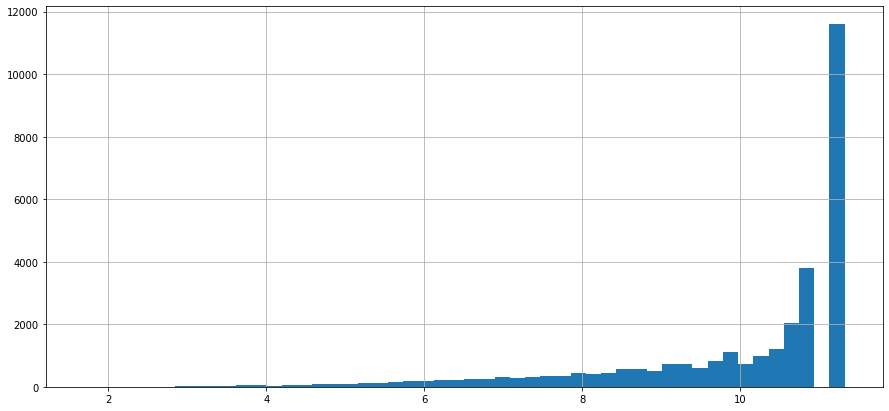

In [ ]:
tfidf.tfidf.hist(bins=50, figsize=(15,7))

In [ ]:
print('Слова с наибольшим tfidf score: ')
tfidf.sort_values(by=['tfidf'], ascending=False).head(30)

Слова с наибольшим tfidf score: 


,tfidf
libatiu,11.32517
lorelei,11.32517
lonley,11.32517
lonli,11.32517
looke,11.32517
lookingsea,11.32517
lookse,11.32517
looooney,11.32517
looooool,11.32517
looov,11.32517


На основе сформированных признаков обучим еще один классификатор, а именно логистическую регрессию:

In [ ]:
from sklearn.metrics import f1_score
def train_model(classifier, feature_vector_train, label, feature_vector_valid):
    classifier.fit(feature_vector_train, label)

    predictions = classifier.predict(feature_vector_valid)    

    return metrics.f1_score(valid_y,predictions)

In [ ]:
import sklearn
from sklearn import linear_model

accuracyORIGINAL = train_model(linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),xtrain_tfidf, df_train['label'], xvalid_tfidf)
print ("Logistic regression Baseline, WordLevel TFIDF: ", accuracyORIGINAL)

KeyboardInterrupt: ignored

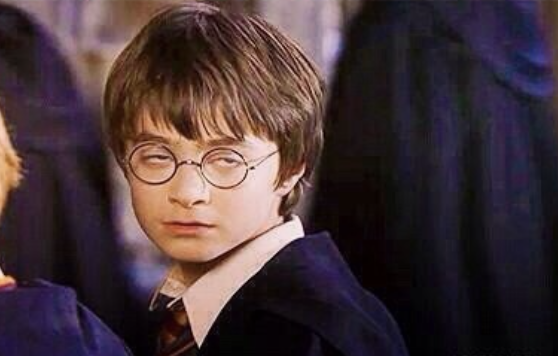

Дальше как-то не вышло...(


